In [2]:
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.0 MB 163.8 kB/s eta 0:00:18
     ---------------------------------------- 0.0/3.0 MB 163.8 kB/s eta 0:00:18
     ---------------------------------------- 0.0/3.0 MB 163.8 kB/s eta 0:00:18
      --------------------------------------- 0.0/3.0 MB 108.9 kB/s eta 0:00:27
      --------------------------------------- 0.0/3.0 MB 108.9 kB/s eta 0:00:27
      --------------------------------------- 0.0/3.0 MB 108.9 kB/s eta 0:00:27
      --------------------------------------- 0.1/3.0 MB 125.8 kB/s eta 0:00:23
      -

DEPRECATION: Loading egg at c:\programdata\anaconda3\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
# Importing necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Downloading historical stock price data
stock_symbol = 'AAPL'
data = yf.download(stock_symbol, start='2010-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.461976,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.473149,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.370185,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.358407,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.400681,447610800


In [6]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542816,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700
2023-12-28,194.139999,194.660004,193.169998,193.580002,193.071426,34049900
2023-12-29,193.899994,194.399994,191.729996,192.529999,192.024185,42628800


In [7]:
# Feature Selection: Using the 'Close' price for prediction
data = data[['Close']]

In [8]:
# Normalizing the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [9]:
# Creating a dataset with features and target
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [10]:
time_step = 100
X, Y = create_dataset(scaled_data, time_step)

In [11]:
# Spliting the data into training and testing sets
train_size = int(len(X) * 0.75)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [12]:
# Reshaping the input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [13]:
# Importing the necessary library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

C:\Users\KIIT\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
# Training the model
model.fit(X_train, Y_train, batch_size=1, epochs=1)

2565/2565 ━━━━━━━━━━━━━━━━━━━━ 152s 57ms/step - loss: 6.3159e-04


In [16]:
# Predicting on the test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [17]:
# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
Y_train = scaler.inverse_transform([Y_train])
Y_test = scaler.inverse_transform([Y_test])

In [18]:
# Calculating RMSE
import math
from sklearn.metrics import mean_squared_error

train_score = math.sqrt(mean_squared_error(Y_train[0], train_predict[:, 0]))
test_score = math.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
print(f'Train Score: {train_score} RMSE')
print(f'Test Score: {test_score} RMSE')

Train Score: 1.5606652997019013 RMSE
Test Score: 7.956546074402206 RMSE


Train predictions shape: (2565, 1)
Test predictions shape: (856, 1)


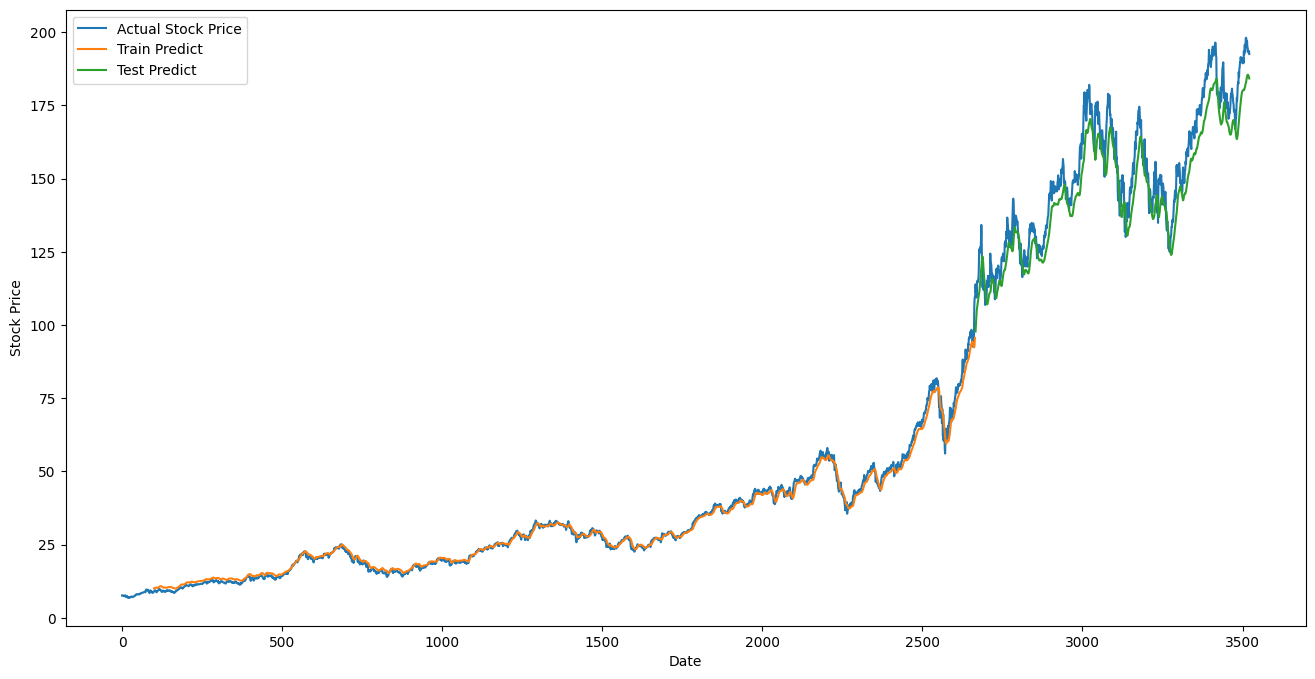

In [21]:
# Check the shapes of the train and test predictions
print(f"Train predictions shape: {train_predict.shape}")
print(f"Test predictions shape: {test_predict.shape}")

# Ensure the correct slicing and assignment
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan

# Adjust the index to correctly fit test predictions
start_index = len(scaled_data) - len(test_predict)
test_predict_plot[start_index:start_index + len(test_predict), :] = test_predict

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Stock Price')
plt.plot(train_predict_plot, label='Train Predict')
plt.plot(test_predict_plot, label='Test Predict')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [24]:
# Saving the model using the native Keras format
model.save('stock_price_lstm_model.keras')

In [25]:
from tensorflow.keras.models import load_model

# Loading the model
model = load_model('stock_price_lstm_model.keras')

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')


C:\Users\KIIT\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
